In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-01-19 16:30:35.959077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 16:30:36.105269: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-19 16:30:37.299929: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/.conda/envs/tensorflow.2.10/lib/:/end/home/rh2310/.conda/envs/tensorfl

In [ ]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
            
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:        
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

In [2]:
GPU_NUM = 0
MEMORY = 10*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[GPU_NUM],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e)    
    


1 Physical GPUs, 1 Logical GPUs


2023-01-19 16:30:41.998244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 16:30:42.666025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:e3:00.0, compute capability: 8.6


In [3]:
sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

# Load Koch Meinhardt dataset


In [4]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/Koch_Meinhardt_2.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [5]:
data.shape

(2, 100, 100, 513)

In [6]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


In [7]:
t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)

#t_star = t_star[-3:-1]
#data = data[..., -3:-1]
T = t_star.shape[0]    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

In [8]:
c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

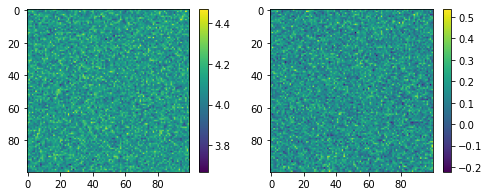

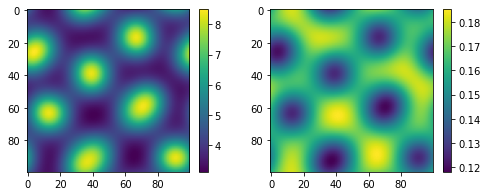

In [9]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

# Derivatives

In [10]:

dxdy = x_size/L
c_x =  np.array([[dxdy  * first_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_x = np.einsum("ctij -> cijt", c_x)
c_y = np.array([[dxdy * first_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_y = np.einsum("ctij -> cijt", c_y)


c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [11]:
dxdy = x_size*y_size/L**2
diff_Y = np.array([[dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [12]:
T

513

In [13]:
c_t.shape

(2, 100, 100, 512)

In [14]:
t_star = t_star[-2:]
data = data[..., -2:]
c_x = c_x[..., -2:]
c_y = c_y[..., -2:]
c_t = c_t[..., -2:]
diff_Y = diff_Y[..., -2:]
T = t_star.shape[0]  

In [15]:
T

2

In [16]:
data.shape

(2, 100, 100, 2)

In [17]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
#indices_sub = indices_all[:, 30:60, 50:80]
#indices_sub = indices_all[:, 30:65, 50:85]
#indices_sub = indices_all[:, 30:65:10, 50:85:10]
indices_sub = indices_all[:, 30:65, 50:85]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'derivatives':[c_x, c_y, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']

obs_inputs = dataset['obs_input']#np.vstack([dataset['obs_input'][first_s],
                        #dataset['obs_input'][second_s]])
obs_outputs = dataset['obs_output']#np.vstack([dataset['obs_output'][first_s],
#                          #dataset['obs_output'][second_s]])

# diff_outputs = dataset['diff_output']#np.vstack([dataset['diff_output'][first_s],
#                          #dataset['diff_output'][second_s]])
der_u_outputs = dataset["der_u"].T#np.vstack([dataset["der_u"][:,first_s].T,
                           #dataset["der_u"][:,second_s].T])
der_v_outputs = dataset["der_v"].T#np.vstack([dataset["der_v"][:,first_s].T,
                           #dataset["der_v"][:,second_s].T])
obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)

# obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs#dataset['pde']
der_X = np.concatenate([obs_inputs, der_u_outputs, der_v_outputs], axis=1)
#der_X = np.concatenate([obs_inputs, der_u_outputs[:,0:1], der_v_outputs[:,0:1]], axis=1)
# obs_der_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)

# pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

#diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)

#diffs_point = np.concatenate([obs_inputs, diff_outputs], axis=1)

In [18]:
der_X.shape

(2450, 9)

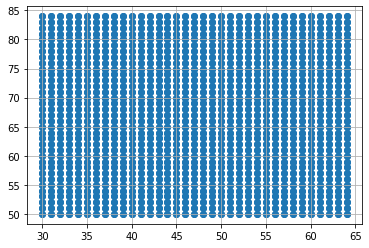

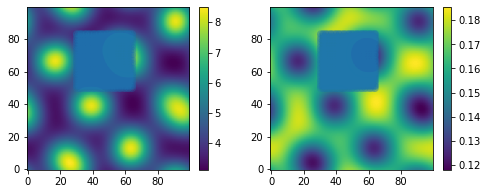

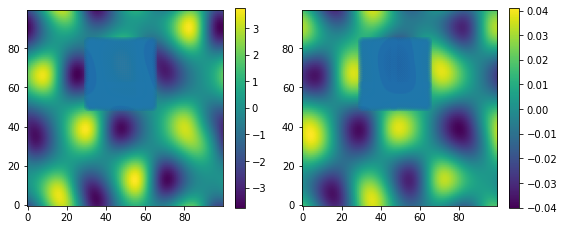

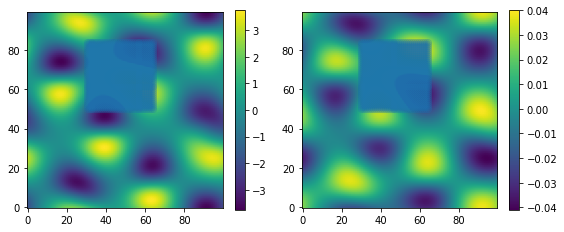

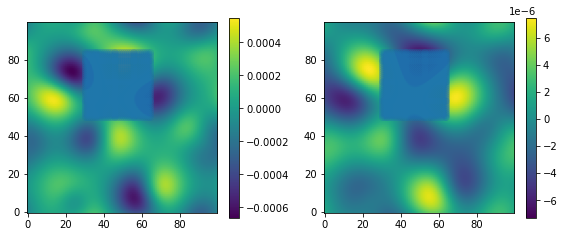

In [19]:
plt.scatter((x_size-1)*obs_X[:,0]/L, (x_size-1)*obs_X[:,1]/L)
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is cnahging in the outer arrays. So, we must transpose them on
##                ploting time
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(data[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_x[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_x[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_y[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_y[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_t[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_t[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

In [20]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)#, pbc_X)
#ds = TINN_Dataset(tf.float32, der_X, obs_X, pde_X)

# ds_der = TINN_Dataset(tf.float32, der_X)
# ds_der_1 = TINN_Dataset(tf.float32, obs_X, der_X_1)
# ds_test = TINN_Dataset(tf.float32, obs_test)
# ds_obs_der = TINN_Dataset(tf.float32, obs_der_X)
# ds = TINN_Dataset(tf.float32, obs_der_X, pde_X)


#ds_obs = TINN_Dataset(tf.float32, obs_X)
#ds_obs = TINN_Dataset(tf.float32, der_X)
ds_obs = TINN_Dataset(tf.float32, obs_X, der_X, pde_X)
#ds_obs = TINN_Dataset(tf.float32, obs_X, pde_X)

In [21]:
ds_obs.sizes

array([2450, 2450, 2450])

In [22]:
class Derivatives_first_order_Loss(Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 3,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=6,
            residual_ret_names=("u_x", "u_y", "u_t", "v_x", "v_y", "v_t"),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        p1= [tf.gradients(outputs[:, i], inputs)[0] for i in range(outputs.shape[1])]
        u_x = tf.cast(p1[0][:, 0], pinn.dtype)
        u_y = tf.cast(p1[0][:, 1], pinn.dtype)
        u_t = tf.cast(p1[0][:, 2], pinn.dtype)
        v_x = tf.cast(p1[1][:, 0], pinn.dtype)
        v_y = tf.cast(p1[1][:, 1], pinn.dtype)
        v_t = tf.cast(p1[1][:, 2], pinn.dtype)
        
        
        u_x_obs = x[:, self.input_dim : self.input_dim + 1]
        u_y_obs = x[:, self.input_dim + 1 : self.input_dim + 2]
        u_t_obs = x[:, self.input_dim + 2 : self.input_dim + 3]
        v_x_obs = x[:, self.input_dim + 3 : self.input_dim + 4]
        v_y_obs = x[:, self.input_dim + 4 : self.input_dim + 5]
        v_t_obs = x[:, self.input_dim + 5 : self.input_dim + 6]

        return (
            (u_x - u_x_obs),
            (u_y - u_y_obs),
            (u_t - u_t_obs), 
            (v_x - v_x_obs),
            (v_y - v_y_obs),
            (v_t - v_t_obs), 
        )

In [27]:
#layers = [3, 1024, 1024, 1024, 8]
#layers = [3, 512, 512, 512, 512, 2]
#layers = [3, 128, 128, 128, 128, 128, 2]
#layers = [3, 128, 128, 2]
#layers = [3, 64,  2]
layers = [3, 4*1024, 4*1024, 2]


pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard(
                    #dtype = pinnKM.dtype,
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    #D_u=PDE_Parameter("D_u", Parameter_Type.VARIABLE, 1.0, dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    #D_v=PDE_Parameter("D_v", Parameter_Type.VARIABLE,  1.0, dtype=pinnKM.dtype),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 0.0001,dtype=pinnKM.dtype, clip_constraint=clip_by_value_zero_lb),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, clip_constraint=clip_by_value_zero_lb),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, clip_constraint=clip_by_value_zero_lb),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 0.01,dtype=pinnKM.dtype, clip_constraint=clip_by_value_zero_lb),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, clip_constraint=clip_by_value_zero_lb),
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 0.1,dtype=pinnKM.dtype, clip_constraint=clip_by_value_zero_lb),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),

    regularise=True
    )
obs_loss = Observation_Loss(layers=layers, 
                           residual_ret_names=("u", "v"),
                           )

der_loss = Derivatives_first_order_Loss(dtype = pinnKM.dtype,
                            regularise=True
                           )
modelKM = tu.TINN(pinnKM, 
                  losses= [obs_loss, der_loss, pde_resKM],
                  norm = L2(),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".12f")

In [24]:
sizes = ds_obs.sizes
ds_obs = ds_obs.shuffle(np.max(sizes))
setattr(ds_obs,"sizes", sizes) 

In [ ]:
results_KM = modelKM.train(epochs = 2000+1,
                          batch_size = 2450,
                          dataset = ds_obs,
                          print_interval=100,
                          stop_threshold = 9e-7,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=None)


Start of epoch 0
total loss: 33.845283627510, total regularised loss: 33.845287322998
Observation_Loss -> 
(1)  u: 27.608903884888 (2)  v: 0.025598939508 
Derivatives_Loss -> 
(3)  u_x: 2.341575384140 (4)  u_y: 2.796998977661 (5)  u_t: 0.000137416908 
(6)  v_x: 0.000328912312 (7)  v_y: 0.000358967809 (8)  v_t: 0.012236071751 

Loss_Koch_Meinhard -> 
(9)  res u: 1.059032201767 (10)  res v: 0.000112867354 
Time taken: 10.70s

Start of epoch 100
total loss: 8.317965159193, total regularised loss: 8.317964553833
Observation_Loss -> 
(1)  u: 2.015313386917 (2)  v: 0.001370685524 
Derivatives_Loss -> 
(3)  u_x: 2.124925136566 (4)  u_y: 4.150589466095 (5)  u_t: 0.000845065748 
(6)  v_x: 0.000367445289 (7)  v_y: 0.001261700876 (8)  v_t: 0.000036527359 

Loss_Koch_Meinhard -> 
(9)  res u: 0.022238332778 (10)  res v: 0.001017143601 
Time taken: 25.89s

Start of epoch 200
total loss: 6.173681025393, total regularised loss: 6.173681735992
Observation_Loss -> 
(1)  u: 1.036154389381 (2)  v: 0.0002

In [ ]:
'sigma_u': 1.0, 'sigma_v': 0.1 , 'mu_u': 1.0, 'rho_u': 1.0, 
'rho_v': 0.025, 'kappa_u': 0.0

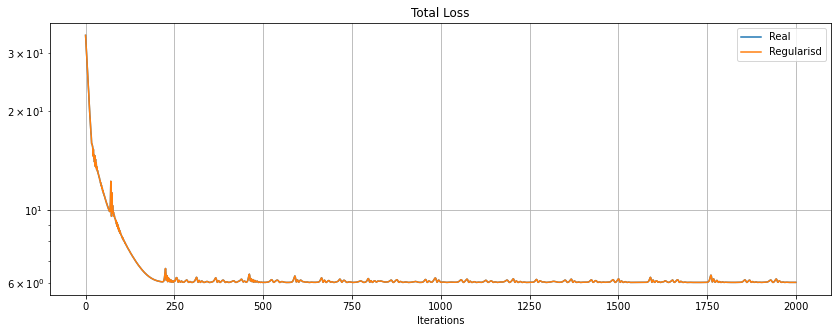

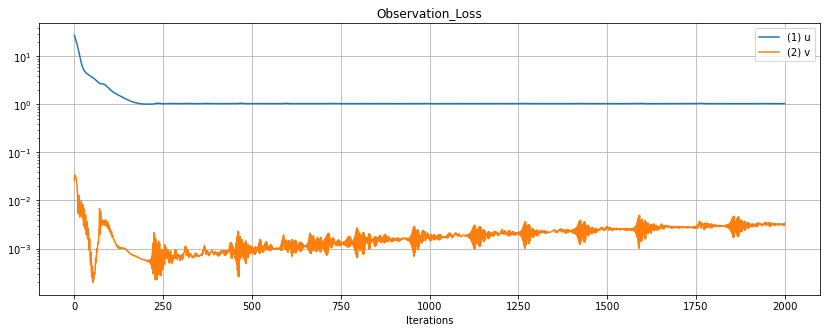

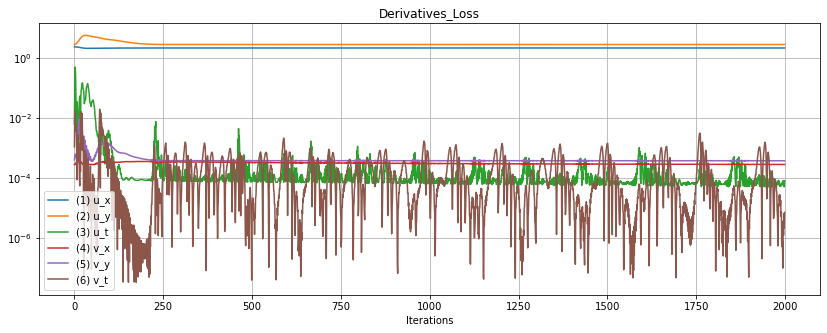

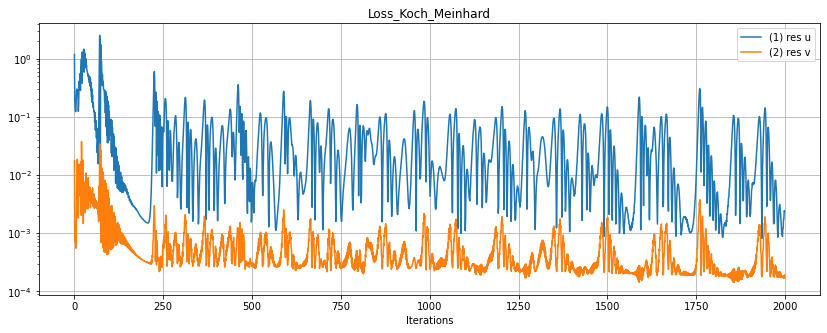

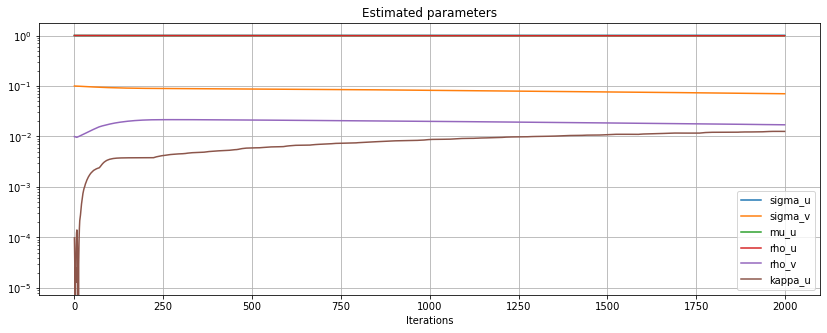

In [26]:
plot_result(merge_dict(results_KM, ), modelKM, param_names=pde_resKM.parameter_names())

In [78]:
test_d = obs_X[:,:3].astype(np.float32)

In [79]:
r = pde_resKM.residual(pinnKM, test_d)
l2 = L2()

print([np.mean(i.numpy()**2) for i in r ])
print(l2.reduce_norm(r).numpy())
print(np.sqrt(l2.reduce_norm(r).numpy()))

[0.018284397, 0.0012099746]
[0.0182844  0.00120997]
[0.13521981 0.03478469]


In [80]:
@tf.function
def derivatives(pinn, x):
    return pde_resKM.derivatives(pinn, x)

In [81]:
(y, u, u_t, u_xx, u_yy, v, v_t, v_xx, v_yy) =  derivatives(pinnKM,test_d)


u1 = u.numpy()[:block_size].reshape(block_x, block_y).T
u2 = u.numpy()[block_size:].reshape(block_x, block_y).T

v1 = v.numpy()[:block_size].reshape(block_x, block_y).T
v2 = v.numpy()[block_size:].reshape(block_x, block_y).T

u_xx1 = u_xx.numpy()[:block_size].reshape(block_x, block_y).T
u_xx2 = u_xx.numpy()[block_size:].reshape(block_x, block_y).T

v_xx1 = v_xx.numpy()[:block_size].reshape(block_x, block_y).T
v_xx2 = v_xx.numpy()[block_size:].reshape(block_x, block_y).T


u_yy1 = u_yy.numpy()[:block_size].reshape(block_x, block_y).T
u_yy2 = u_yy.numpy()[block_size:].reshape(block_x, block_y).T

v_yy1 = v_yy.numpy()[:block_size].reshape(block_x, block_y).T
v_yy2 = v_yy.numpy()[block_size:].reshape(block_x, block_y).T

u_t1 = u_t.numpy()[:block_size].reshape(block_x, block_y).T
u_t2 = u_t.numpy()[block_size:].reshape(block_x, block_y).T

v_t1 = v_t.numpy()[:block_size].reshape(block_x, block_y).T
v_t2 = v_t.numpy()[block_size:].reshape(block_x, block_y).T

In [82]:
der_u_outputs.shape

(2450, 3)

In [83]:
print(np.sqrt(np.mean((u_xx1-der_u_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_yy1-der_u_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_t1-der_u_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_xx1-der_v_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_yy1-der_v_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_t1-der_v_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))

1.2921332329273982
1.0141573294625894
0.030167786825400424
0.05165592999841287
0.047735985517326995
0.0012352146327054537


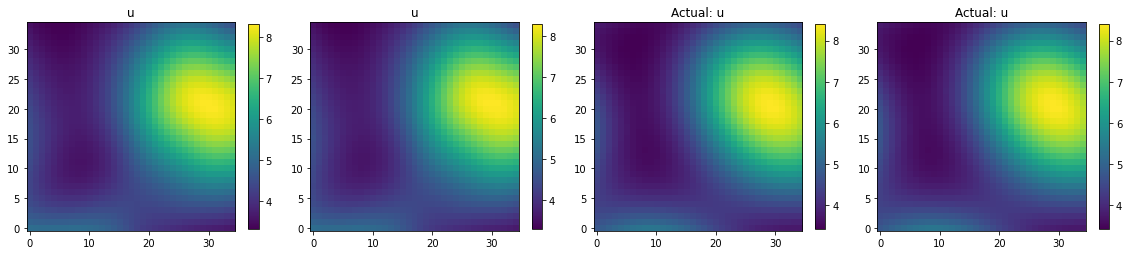

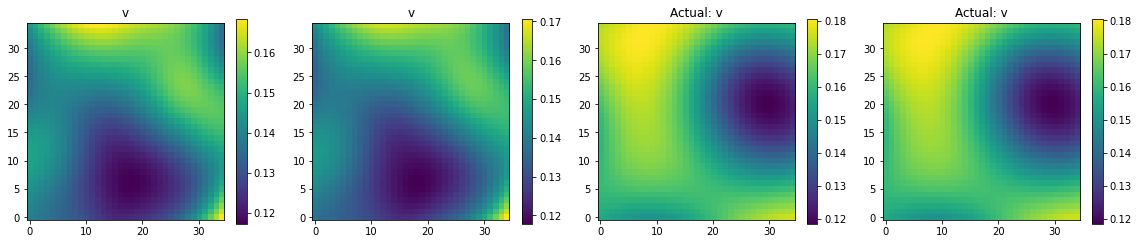

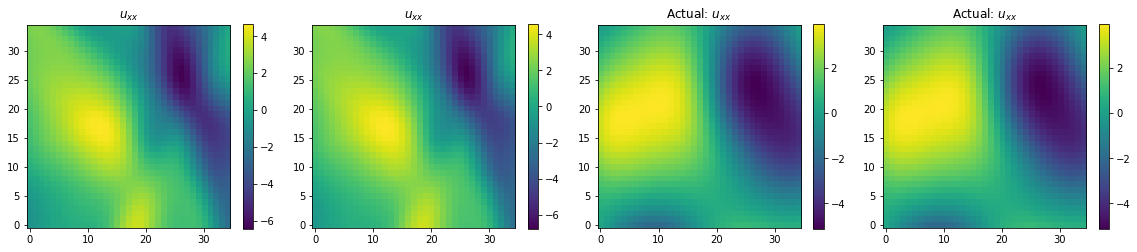

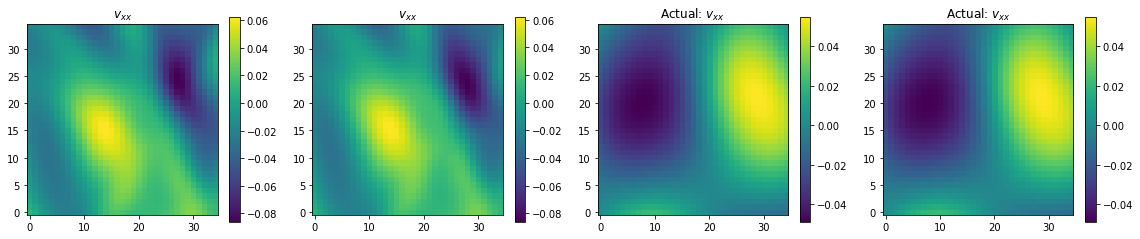

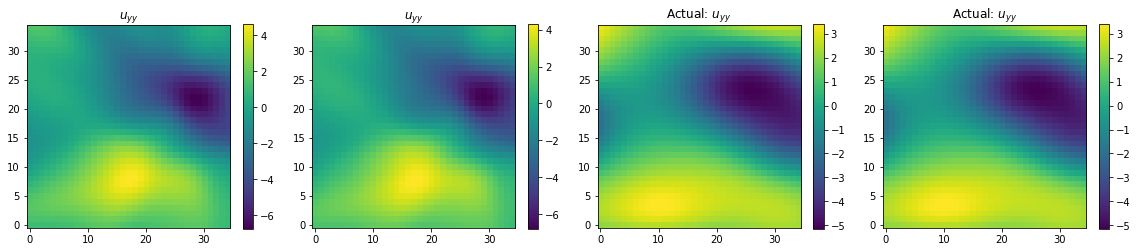

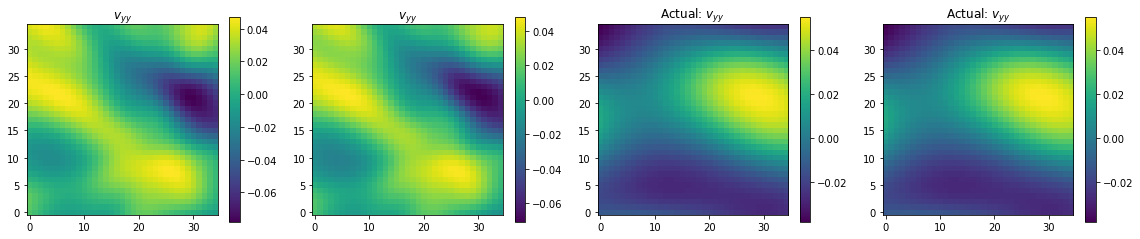

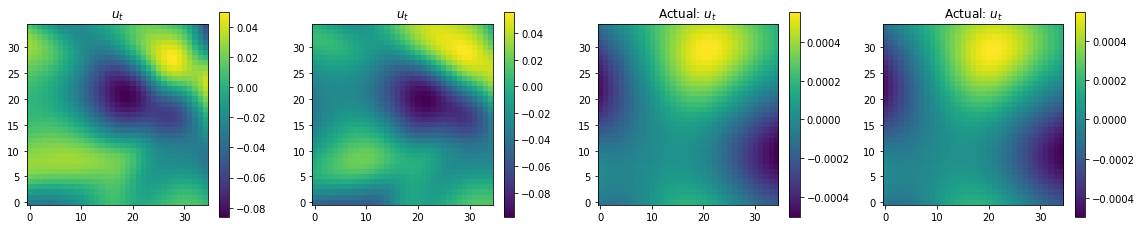

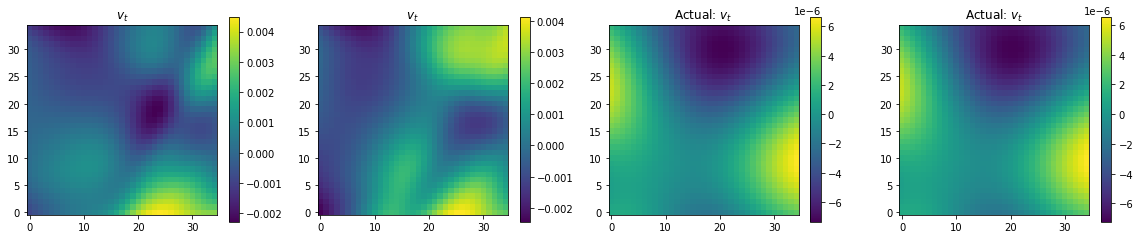

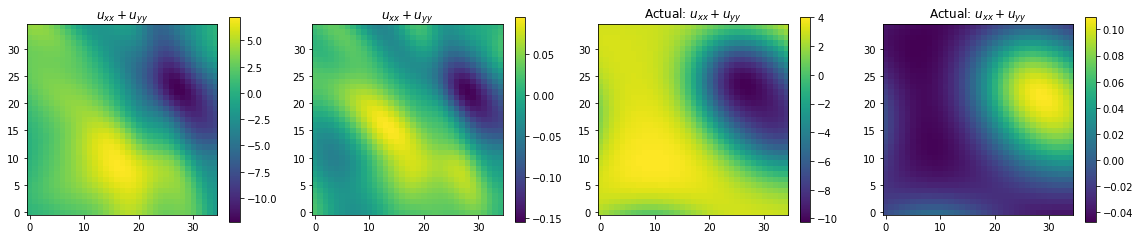

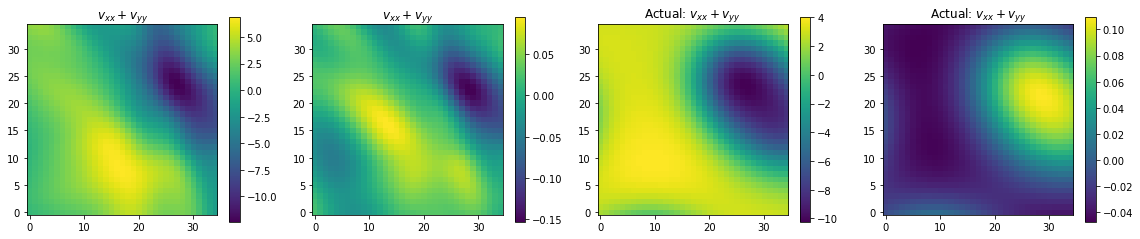

In [88]:
def p(m1, m2,  m3, m4, title=""):
    _ = plt.figure(figsize=(16,6))    
    plt.subplot(141)
    plt.title(title)
    plt.imshow(m1,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(142)
    plt.title(title)
    plt.imshow(m2,
               origin='lower')
    plt.colorbar(shrink=.5)

    plt.subplot(143)
    plt.title("Actual: " + title)
    plt.imshow(m3.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(144)
    plt.title("Actual: " + title)
    plt.imshow(m4.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.tight_layout()
    plt.show()
p(u1, u2, obs_outputs[:block_size,0], obs_outputs[block_size:,0], "u")
p(v1, v2, obs_outputs[:block_size,1], obs_outputs[block_size:,1], "v")
p(u_xx1, u_xx2, der_u_outputs[:block_size,0], der_u_outputs[block_size:,0], r"$u_{xx}$")
p(v_xx1, v_xx2, der_v_outputs[:block_size,0], der_v_outputs[block_size:,0], r"$v_{xx}$")
p(u_yy1, u_yy2, der_u_outputs[:block_size,1], der_u_outputs[block_size:,1], r"$u_{yy}$")
p(v_yy1, v_yy2, der_v_outputs[:block_size,1], der_v_outputs[block_size:,1], r"$v_{yy}$")
p(u_t1, u_t2, der_u_outputs[:block_size,2], der_u_outputs[block_size:,2], r"$u_{t}$")
p(v_t1, v_t2, der_v_outputs[:block_size,2], der_v_outputs[block_size:,2], r"$v_{t}$")

p(u_xx1+u_yy1, (v_xx1+v_yy1), dataset['diff_output'][:block_size,0], dataset['diff_output'][:block_size,1], r"$u_{xx} + u_{yy}$")
p(u_xx2+u_yy2, (v_xx2+v_yy2), dataset['diff_output'][block_size:,0], dataset['diff_output'][block_size:,1], r"$v_{xx} + v_{yy}$")